### The aim of the project is to develop a model predicting the critical temperature of various superconductors.

This project is based on the following publicly available data set:https://www.kaggle.com/datasets/tunguz/superconductivty-data-data-set/data


Rough outline of project: 

1 Exploratory data analysis :
- Data visualization
- Missing values
- Outliers 

2 Preprocessing:
- make sure all features are numerical and if not probably one hot encoding
- Feature scaling 
- Feature selection/engineering through a PCA for example (If non linear, maybe other type of feature extraction like polynomial features)

3 Training/testing models:
- Train/test split
- optimisation of hyperparameters of best models with grid/randomized search CV
- OPTIONAL: tweak preprocessing of step 2 to optimize if possible

4: Retraining of selected model on the whole training data and final evaluation. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from multiprocessing import cpu_count
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from scipy.cluster import hierarchy

n_cpu = cpu_count()-2

The first step is to perform an exploratory data analysis. 
Let us load the data set and see what it looks like.

In [2]:
df = pd.read_csv("superconductor.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21263 entries, 0 to 21262
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21263 non-null  int64  
 1   mean_atomic_mass                 21263 non-null  float64
 2   wtd_mean_atomic_mass             21263 non-null  float64
 3   gmean_atomic_mass                21263 non-null  float64
 4   wtd_gmean_atomic_mass            21263 non-null  float64
 5   entropy_atomic_mass              21263 non-null  float64
 6   wtd_entropy_atomic_mass          21263 non-null  float64
 7   range_atomic_mass                21263 non-null  float64
 8   wtd_range_atomic_mass            21263 non-null  float64
 9   std_atomic_mass                  21263 non-null  float64
 10  wtd_std_atomic_mass              21263 non-null  float64
 11  mean_fie                         21263 non-null  float64
 12  wtd_mean_fie      

We see that we have more than 80 features. We see that everyhting is numerical with no missing values. 
Let us search for duplicated rows and remove them if any

In [3]:
# Find duplicated rows
duplicated_rows = df[df.duplicated()]

# Display duplicated rows
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass   
8503                    4         76.444563             51.381751  \
12598                   2         39.513500             45.227500   
12736                   2        105.962750            121.538200   
12798                   2        141.926690            149.730928   
12829                   2        141.568190            141.568190   
...                   ...               ...                   ...   
16715                   2         60.332250             55.636875   
16734                   2        141.568190            131.835828   
20068                   2        114.090000            119.228900   
20069                   2        118.289000            120.024500   
20072                   3        143.662190            135.668337   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass   
8503           59.356672              35.040763             1.199541  \
12598     

There are 66 duplicated rows so we remove them from our dataset. 

In [4]:
# Remove duplicated rows
df = df.drop_duplicates()

# Display DataFrame without duplicates
print("DataFrame without Duplicates:")
print(df)

DataFrame without Duplicates:
       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass   
0                       4         88.944468             57.862692  \
1                       5         92.729214             58.518416   
2                       4         88.944468             57.885242   
3                       4         88.944468             57.873967   
4                       4         88.944468             57.840143   
...                   ...               ...                   ...   
21258                   4        106.957877             53.095769   
21259                   5         92.266740             49.021367   
21260                   2         99.663190             95.609104   
21261                   2         99.663190             97.095602   
21262                   3         87.468333             86.858500   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass   
0              66.361592              36.116612             1.181795 

To look for outliers we will use the IQR method (interquartile range method): it computes the difference between the 75th percentile and the 25th percentile and considers points that fall below Q1 - Q_t * IQR or above Q3 + Q_t * IQR as outliers.

In [5]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)

# Calculate IQR (Interquartile Range)
IQR = Q3 - Q1

# Find outliers using IQR method
Q_t = 10
outliers = ((df < (Q1 - Q_t * IQR)) | (df > (Q3 + Q_t * IQR))).any(axis=1)

# Display rows with outliers
print(df[outliers])

       number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass   
2117                    2         48.739250             15.508657  \
2118                    2         25.554500             13.300586   
2119                    2         48.739250             15.508657   
2120                    2         48.739250             15.508657   
2121                    2         25.554500             13.300586   
...                   ...               ...                   ...   
20050                   4         68.288893             55.647697   
20051                   4         68.288893             55.708355   
20197                   2         75.458085             54.308957   
20198                   2         75.458085             54.308957   
20658                   2         72.458076             17.767593   

       gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass   
2117           32.039477              13.187149             0.373280  \
2118           21.670209   

With a value of Q_t=1.5, around half of the dataset seems to have potential outliers. This indicates that we are probably not using an appropriate definition of outliers for our problem. We therefore take Q_t=10 to focus only on the most extreme potential outliers. There are 300 rows that are potential outliers. To delve deeper, let us see which features are potentially problematic. (We see on the next line that the target does not have potential outliers for Q_t=10). 

In [6]:
outlier_dim = ((df < (Q1 - Q_t * IQR)) | (df > (Q3 + Q_t * IQR)))
with pd.option_context('display.max_rows', None): 
    print(outlier_dim.sum())

number_of_elements                   0
mean_atomic_mass                     0
wtd_mean_atomic_mass                 0
gmean_atomic_mass                    0
wtd_gmean_atomic_mass                0
entropy_atomic_mass                  0
wtd_entropy_atomic_mass              0
range_atomic_mass                    0
wtd_range_atomic_mass                0
std_atomic_mass                      0
wtd_std_atomic_mass                  0
mean_fie                             0
wtd_mean_fie                         0
gmean_fie                            0
wtd_gmean_fie                        0
entropy_fie                          0
wtd_entropy_fie                      0
range_fie                            0
wtd_range_fie                        0
std_fie                              0
wtd_std_fie                          0
mean_atomic_radius                   0
wtd_mean_atomic_radius               0
gmean_atomic_radius                  0
wtd_gmean_atomic_radius              0
entropy_atomic_radius    

We see that most of the extreme outliers are related to wtd_range_FusionHeat and wtd_std_FusionHeat, with a few for wtd_range_Density and one for mean_ElectronAffinity. We see that there are no potential outliers for range_FusionHeat, std_FusionHeat and wtd_range_Density. Assuming the weighted features are obtained from the original ones, maybe there was an issue for the weighting of these features. However the other weighted features seem fine. A detailed knowledge of how weighting is defined for each features matter. In this instance, domain knowledge could prove valuable to check if weighting is done correctly to create these features.

To get more insight into how features are correlated with each other, we can plot the correlation matrix (bear in mind this only displays linear correlations). 
From this we may find it judicious to do some feature engineering. 

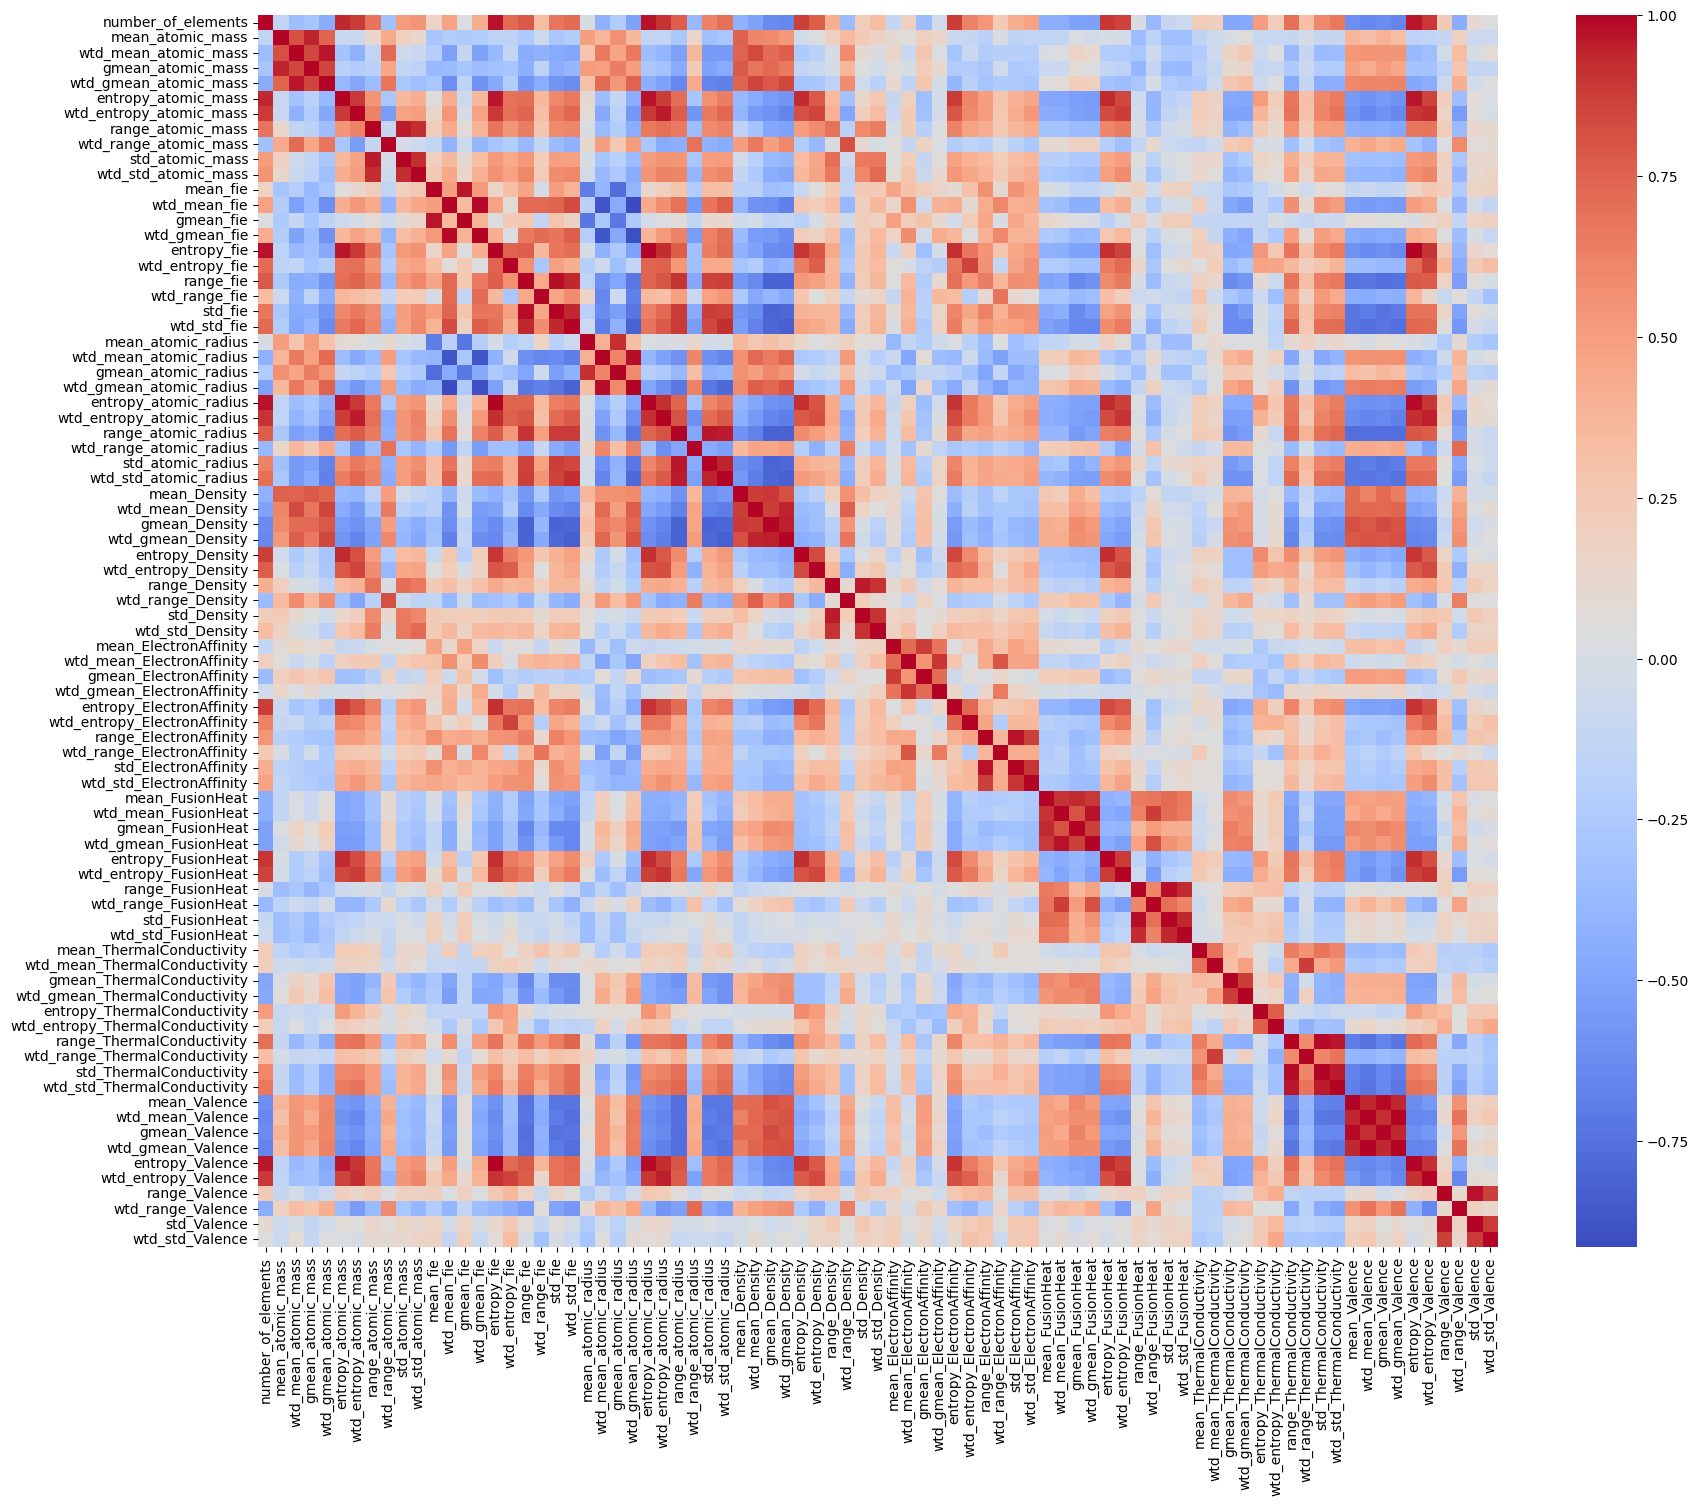

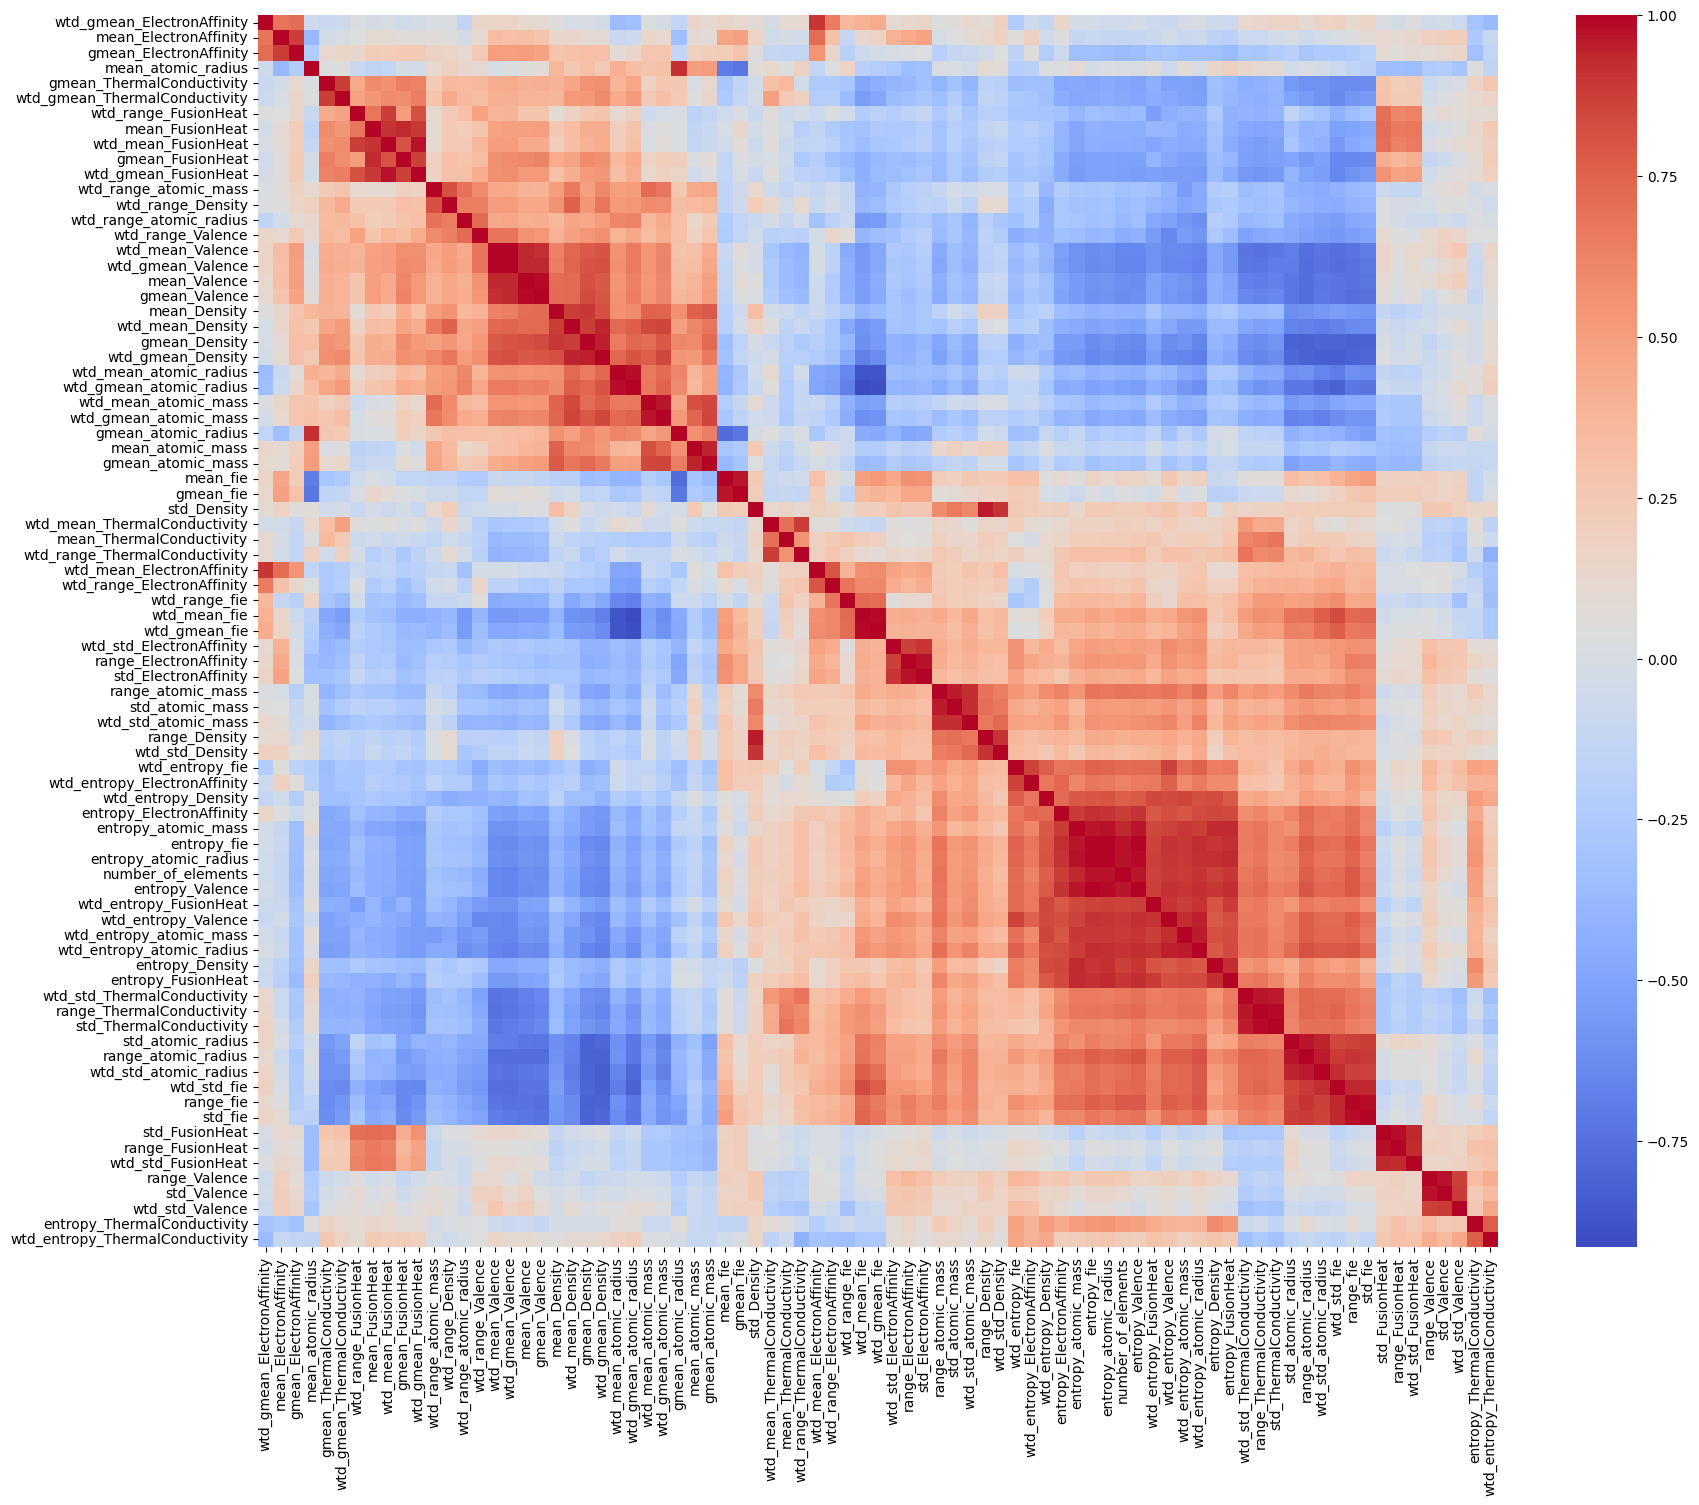

In [7]:
# We display the correlation matrix without our target 
correlation_matrix = df.drop('critical_temp', axis=1).corr()
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix, cmap='coolwarm', annot=False)

# We add hierarchical clustering based on correlation
linkage = hierarchy.linkage(correlation_matrix, method='average', metric='correlation')
order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']
correlation_matrix_sorted = correlation_matrix.iloc[order, order]

# Display the reordered correlation matrix
plt.figure(figsize=(20, 16))
sns.heatmap(correlation_matrix_sorted, cmap='coolwarm', annot=False)

plt.show()

Interpretation: 

The regular matrix: since the features are sorted by name, we see that features revolving around a similar concept are pretty correlated (we see several NxN squares around the diagonal with N=3 on average). However we see strong correlations or anticorrelations away from the diagonal (multicollinearity), whence it makes sense to display a hierarchical clustering of the correlation matrix.

The reordered matrix: We distinguish three clusters. Because of the number and variety of features, interpretation is not straightforward. Maybe some time and domain knowledge would help. 

In terms of feature engineering we consider two options. The first one is to perform a PCA. The second one is to select among the features either ones without 'wtd' and 'std' as a suffix, or doing the opposite meaning keeping features with the same suffix. We will attempt both later on after a first bare attempt.

Let us now visualize our features, and let's have a closer look in particular to our features with potential outliers. 

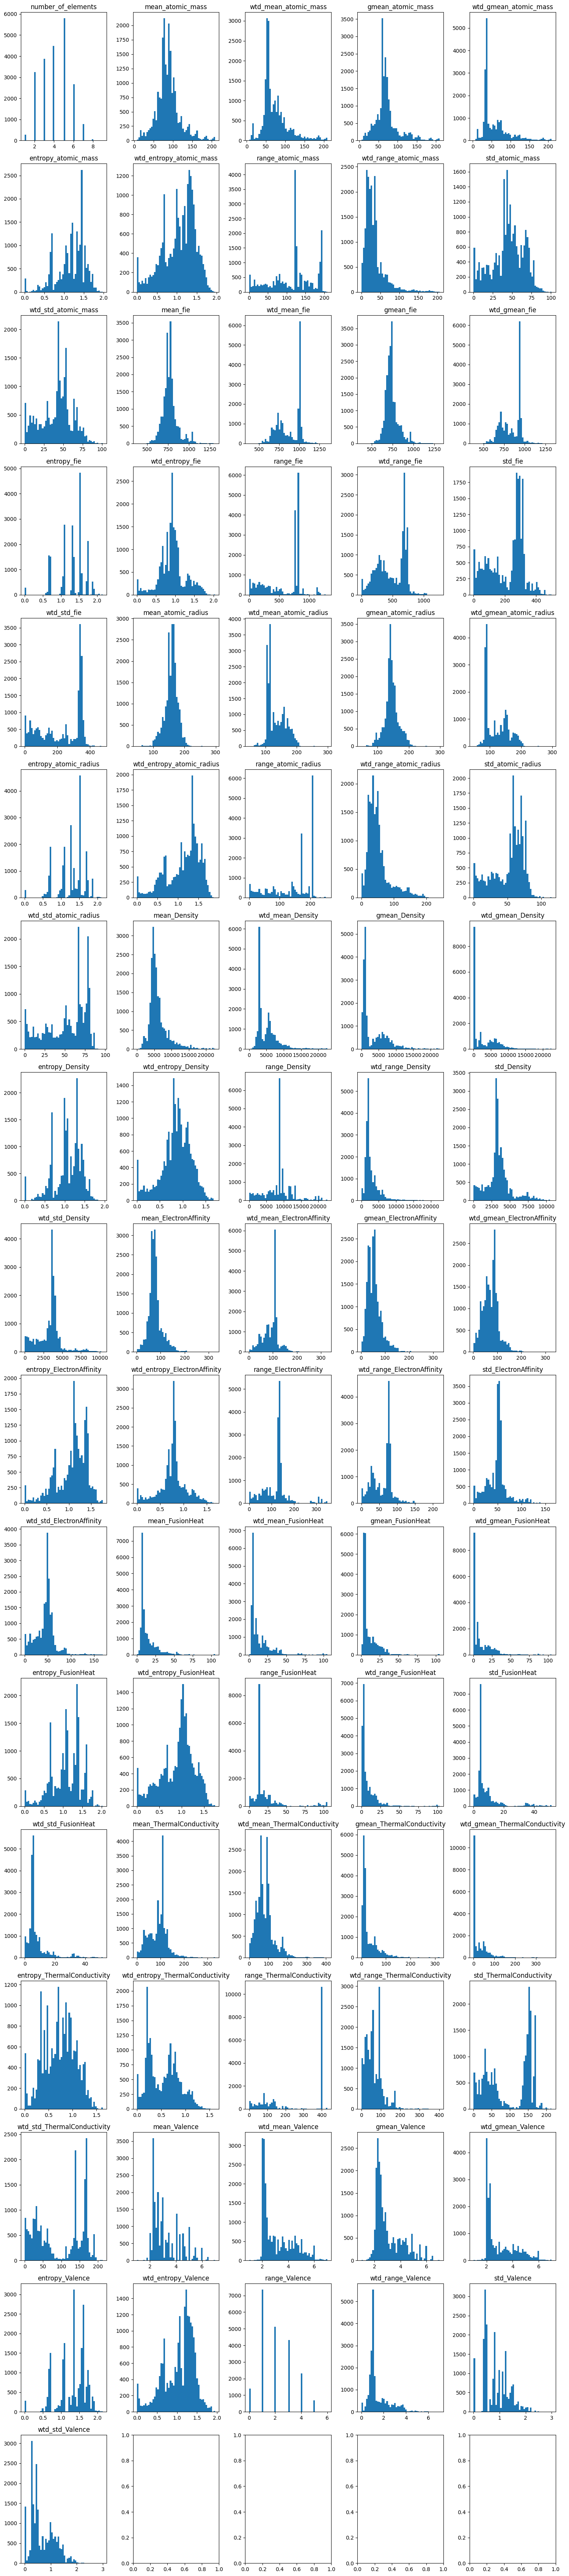

In [8]:
feature_names = list(df.columns) #creates a list with the name of all the columns
target = feature_names.pop(-1) #creates our target variable and removes it from the features list

n_features = len(feature_names) #number of features
n_cols = 5 #number of columns we want to display
n_rows = (n_features + n_cols - 1) // n_cols  # This line calculates the number of rows needed for the grid. 

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4*n_rows))

for idx, column in enumerate(feature_names):
   ax = axes[idx // n_cols, idx % n_cols]
   ax.hist(df[column], bins=50)
   ax.set_title(column)

plt.tight_layout()
plt.show()

We see that most features are sharply peaked with heavy tails. Let us look at the variance of the features closer.

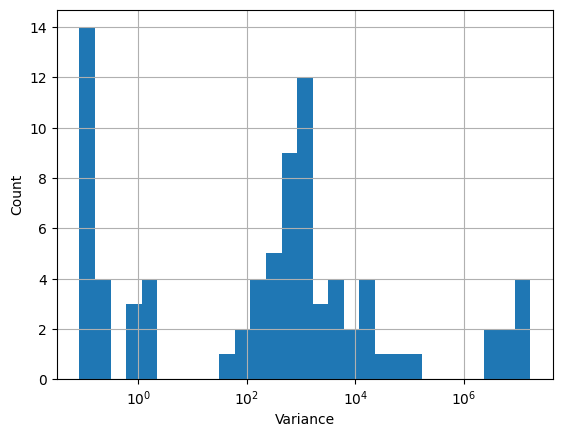

In [9]:
var = df.var()

var_log_min = np.log10(var.min())
var_log_max = np.log10(var.max())

ax = var.hist(bins=np.logspace(var_log_min, var_log_max, 30))
plt.xscale('log')
plt.ylabel('Count')
plt.xlabel('Variance')
plt.show()

We see indeed that we have a few features having more extreme variance because of the potential outliers we detected earlier. 

Let us also plot the distribution of our target

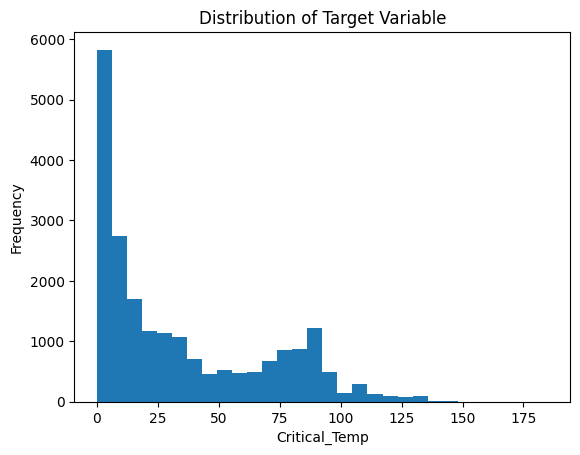

In [10]:
plt.hist(df[target], bins=30)
plt.xlabel('Critical_Temp')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

We see most supraconductors have a near 0 critical temperature, and very few have a high critical temperature as expected. We see a second peak around 80K, probably corresponding to cuprates, a much studied class of materials for their relatively high critical temperatures. Maybe an interesting idea would be te have two models, one for low temperatures conductors, and one for cuprates. 

Before proceeding to preprocessing, let us see the correlation between the features and the target. To this aim we will compute the Pearson coefficients (keep in mind that Pearson coefficients look for linear correlations only). 

In [11]:
# Calculate the correlation matrix
correlation_matrix = df.corr()

# Extract the correlation of each feature with the target variable
correlation_with_target = correlation_matrix[target]

# Sort the correlations in descending order
correlation_with_target_sorted = correlation_with_target.abs().sort_values(ascending=False)

# Display the sorted correlations
with pd.option_context('display.max_rows', None): 
    print("Correlation with target variable (critical_temp):")
    print(correlation_with_target_sorted)

Correlation with target variable (critical_temp):
critical_temp                      1.000000
wtd_std_ThermalConductivity        0.720960
range_ThermalConductivity          0.687282
range_atomic_radius                0.653394
std_ThermalConductivity            0.653232
wtd_mean_Valence                   0.631924
wtd_entropy_atomic_mass            0.626536
wtd_gmean_Valence                  0.615130
wtd_entropy_atomic_radius          0.602986
number_of_elements                 0.600394
range_fie                          0.600179
mean_Valence                       0.599489
wtd_std_atomic_radius              0.598972
entropy_Valence                    0.598024
wtd_entropy_Valence                0.589204
wtd_std_fie                        0.581442
gmean_Valence                      0.572392
entropy_fie                        0.567156
wtd_entropy_FusionHeat             0.562808
std_atomic_radius                  0.559132
entropy_atomic_radius              0.558249
entropy_FusionHeat        

Let us proceed to the preprocessing. We start with the feature selection approach mentioned earlier.

<span style="color: teal;">At this stage we had selected a subset of features as explained above. 
However we comment it out because it did not improve performance.</span>
```python
regular_df = df.loc[:, ~df.columns.str.startswith(('wtd', 'std'))]
regular_df.info()
```

<span style="color: teal;">Do not forget to remove duplicated rows again after performing such a step.</span>

We continue with a sampling, we expect to use algorithms like random forests that will be significantly slower than linear algorithms so to have a first idea of performances we sample the data set. We can put the sampling ratio to 1 at the end to include the full data set. 
After sampling we can proceed with a scaling of the data as well as a PCA.

In [12]:
# We take a sample to make the code faster and we can set frac=1 in the final run

df_sample = df.sample(frac=1, random_state=42)
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 21197 entries, 1056 to 15829
Data columns (total 82 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   number_of_elements               21197 non-null  int64  
 1   mean_atomic_mass                 21197 non-null  float64
 2   wtd_mean_atomic_mass             21197 non-null  float64
 3   gmean_atomic_mass                21197 non-null  float64
 4   wtd_gmean_atomic_mass            21197 non-null  float64
 5   entropy_atomic_mass              21197 non-null  float64
 6   wtd_entropy_atomic_mass          21197 non-null  float64
 7   range_atomic_mass                21197 non-null  float64
 8   wtd_range_atomic_mass            21197 non-null  float64
 9   std_atomic_mass                  21197 non-null  float64
 10  wtd_std_atomic_mass              21197 non-null  float64
 11  mean_fie                         21197 non-null  float64
 12  wtd_mean_fie        

In [13]:
X=df_sample[feature_names]
y=df_sample[target]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Scale the features

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

<span style="color: teal;">We keep the PCA code for reference but we comment it out because we obtained better performance without it. When performing the PCA we saw that we can explain most of the variance with the first 20 components, and virtually everything with 35. 
If it turns out that we are under the curse of dimensionality, we can come back to this section to decide how many components we would like to retain.</span>
```python
pca = PCA()  # We don't specify number of components yet because we don't know how many we want to retain.
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)
```
```python
pca.explained_variance_ratio_
scree = (pca.explained_variance_ratio_*100).round(2)
scree
scree_cum = scree.cumsum().round()
scree_cum
```
```python
x_list = range(1, len(feature_names)+1)
list(x_list);
plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rank of inertia axis")
plt.ylabel("inertia percentage")
plt.title("scree plot of eigenvalues")
plt.show(block=False)
```

We now proceed to the training of our models. For this Regression problem we chose Linear Regression as a benchmark, and trained a Support Vector Regressor, Gradient Boosting Regressor, Random Forest Regressor, XGBoost Regressor and a KNeighbors Regressor. 

Bear in mind that with the full data set the training takes time for most models 
(approximately one hour each for this randomized search cross validation with 20 iterations)

We display the training and validation scores to makes sure we are not under or overfitting.

In [16]:
# We comment out models that were underperforming, 
# so that we can scan a lot of hyperparameters for our best performing one XGBoost (RFR was very close)

best_score = -float('inf')
best_model = None
best_params = None

models = {
    #'LinearRegression': LinearRegression(),
    #'SVM': SVR(),
    #'GradientBoostingRegressor': GradientBoostingRegressor(),
    #'RandomForestRegressor': RandomForestRegressor(),
    'XGBoost': XGBRegressor(),
    #'kNN': KNeighborsRegressor(),
}

param_dict = {
    'LinearRegression': {'dummy_param': [None]},  # No hyperparameters to tune for LinearRegression
    'SVM': {'kernel': ['rbf'], 'C': np.linspace(1, 100, num=100)},
    'GradientBoostingRegressor': {'n_estimators': list(range(10, 1000)), 'learning_rate': np.linspace(0.01, 0.1, num=10), 'max_depth': list(range(1, 10))},
    'RandomForestRegressor': {'n_estimators': list(range(10, 1000)),'max_depth': list(range(1, 15))},
    'XGBoost': {'n_estimators': list(range(10, 1000)), 'learning_rate': np.logspace(-1, 0, num=100),'max_depth': list(range(10, 25)),'reg_alpha': np.logspace(-1, 1, num=10),'reg_lambda': np.logspace(-1, 1, num=10)},
    'kNN': {'n_neighbors': list(range(2, 12)), 'weights': ['uniform', 'distance']},
}

param_dict = {k: v for k, v in param_dict.items() if k in models}  # In case a model is commented in the `models` dict

results = {}
best_fit = {}

for name, model in models.items():
    params = param_dict[name]
    random_search = RandomizedSearchCV(model, params, cv=5, n_jobs=n_cpu, n_iter=20, return_train_score=True)
    random_search.fit(X_train_scaled, y_train)
    
    train_score = random_search.cv_results_['mean_train_score']
    val_score = random_search.cv_results_['mean_test_score']
    
    results[name] = {
        'best_params': random_search.best_params_,
        'best_score': random_search.best_score_,
        'train_score': train_score,
        'val_score': val_score
    }
    
    if random_search.best_score_ > best_score:
        best_score = random_search.best_score_
        best_model = random_search.best_estimator_
        best_params = random_search.best_params_
    
    print(f"Model: {name}")
    print(f"Best params: {results[name]['best_params']}")
    print(f"Best score: {results[name]['best_score']}")
    print(f"Mean train score: {train_score}")
    print(f"Mean validation score: {val_score}")
    print()

Model: XGBoost
Best params: {'reg_lambda': 2.1544346900318834, 'reg_alpha': 10.0, 'n_estimators': 826, 'max_depth': 11, 'learning_rate': 0.2154434690031884}
Best score: 0.9173121380690592
Mean train score: [0.98671576 0.98671582 0.98671078 0.986382   0.98647663 0.98657519
 0.98671604 0.98649128 0.98638797 0.98651257 0.98671249 0.986709
 0.98671601 0.98671573 0.98671584 0.98661532 0.98671307 0.98649568
 0.98671419 0.98671579]
Mean validation score: [0.89892568 0.89601156 0.90647141 0.90957788 0.91567555 0.88686834
 0.90378632 0.91327307 0.91731214 0.90953835 0.91610555 0.91533655
 0.9118556  0.90904185 0.91378722 0.91564647 0.91315712 0.91285603
 0.90205158 0.89947347]



In [17]:
# Final evaluation on test set using the best model from RandomizedSearchCV
best_model.fit(X_train_scaled, y_train)
y_pred = best_model.predict(X_test_scaled)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Best Model: {best_model.__class__.__name__}, Best params - {best_params}, MSE - {mse}, R^2 - {r2}')

Best Model: XGBRegressor, Best params - {'reg_lambda': 2.1544346900318834, 'reg_alpha': 10.0, 'n_estimators': 826, 'max_depth': 11, 'learning_rate': 0.2154434690031884}, MSE - 97.61263412300539, R^2 - 0.9182387558886743


Throughout several tests, it seems that XGBoost and Random Forests were the best performing models with a marginal advantage for XGBoost. 

Having selected our best model with optimized regularization parameters, we performed one last training of our model, this time on the full training set. 

We are satisfied with our final performance score with $R^2\sim0.92$ which reproduces the one found in the paper: "Hamidieh, Kam, A data-driven statistical model for predicting the critical temperature of a superconductor, Computational Materials Science, Volume 154, November 2018, Pages 346-354"

Finally we display the predicted values with respect to the actual values for the critical temperature.

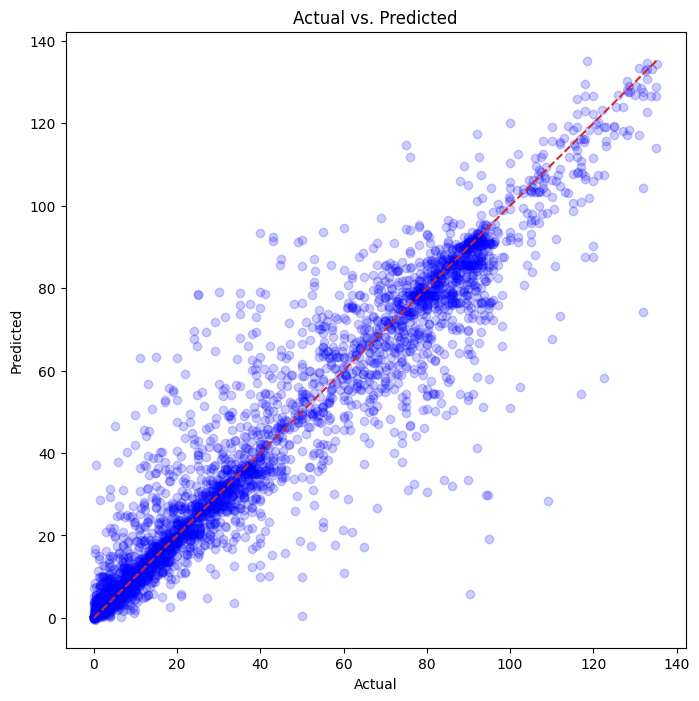

In [18]:
T_max = max(y_test.max(), y_pred.max())
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, color='blue', alpha=0.2)
plt.plot([0, T_max], [0, T_max], ls='--', color='tab:red')
plt.title('Actual vs. Predicted')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.show()